In [16]:
!pip install --quiet transformers datasets evaluate accelerate

In [17]:
!gdown 1oUKScMHKFS0UfgVVbb1sPpcF_B4BNco4 -O dataset.zip
!unzip -o dataset.zip -d dataset
!rm dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1oUKScMHKFS0UfgVVbb1sPpcF_B4BNco4
To: /content/dataset.zip
100% 503k/503k [00:00<00:00, 53.8MB/s]
Archive:  dataset.zip
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


In [18]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, AutoConfig
import evaluate
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
MODEL_NAME="HooshvareLab/bert-fa-base-uncased"
MODEL_NAME="FacebookAI/xlm-roberta-large"
MODEL_NAME="pedramyazdipoor/persian_xlm_roberta_large"
MODEL_NAME="wietsedv/xlm-roberta-base-ft-udpos28-fa"
MODEL_NAME="HooshvareLab/albert-fa-zwnj-base-v2"
# MODEL_NAME="HooshvareLab/roberta-fa-zwnj-base"
MODEL_NAME="m3hrdadfi/albert-fa-base-v2-clf-persiannews"
MODEL_NAME="wietsedv/xlm-roberta-base-ft-udpos28-fa"

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [21]:
# def preprocess_function(dataframe):
#     return tokenizer(dataframe["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
def preprocess_function(data):
    for i in range(len(data["label"])):
      data["label"][i]=label2id[data["label"][i]]
    # return tokenizer(data["text"],add_special_tokens = True,
    #                  return_token_type_ids = True,
    #                  return_tensors = 'pt',
    #                  padding = True,
    #                  return_offsets_mapping = True,
    #                  truncation = 'only_first',
    #                  max_length = 32)
    return tokenizer(data["text"], truncation=True,padding=True,max_length=50, add_special_tokens = True)

In [22]:
TRAIN_FILE="dataset/train.csv"
TEST_FILE="dataset/test.csv"

In [23]:
train_df= pd.read_csv(TRAIN_FILE)
# test_df= pd.read_csv(TEST_FILE)

In [24]:
dataset = load_dataset('csv', data_files={'train': TRAIN_FILE,'test': TEST_FILE})

In [25]:
id2label = {}
label2id = {}
#TODO: use dataset["train"]["label"].unique()
emotions=train_df["label"].unique()
index=0
for emotion in emotions:
  id2label[index]=emotion
  label2id[emotion]=index
  index+=1
num_classes=len(emotions)

In [26]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1151 [00:00<?, ? examples/s]

In [27]:
tokenized_dataset["train"][2]

{'text': '" کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم بعد از حدود 2 ماه استفاده « متاسفانه باخبر شدیم » که فردی در ایرانشهر به حداقل 41 دختر تجاوز کرده . امیدواریم با همکاری نمایندگان محترم مجلس و دستگاه قضا ، دیگه به این راحتی باخبر نشیم .',
 'label': 0,
 'input_ids': [0,
  44,
  26159,
  870,
  15598,
  14109,
  176,
  412,
  33597,
  12004,
  376,
  11174,
  68614,
  167597,
  376,
  1533,
  270,
  22330,
  116,
  8723,
  4303,
  94,
  118725,
  412,
  38323,
  2333,
  3548,
  340,
  403,
  100373,
  175,
  2523,
  42121,
  178,
  77611,
  6478,
  33514,
  85848,
  5205,
  6,
  5,
  212342,
  412,
  37373,
  102083,
  64057,
  9580,
  65,
  20138,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
config = AutoConfig.from_pretrained("HooshvareLab/albert-fa-zwnj-base-v2")
config.update({
    "num_labels":num_classes,
    "id2label":id2label,
    "label2id":label2id
})

In [30]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_NAME, config=config
# )

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_classes, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at wietsedv/xlm-roberta-base-ft-udpos28-fa and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [33]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=3e-5,
    # max_seq_len = 256,
    gradient_accumulation_steps = 8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [35]:
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.505347,0.452650
2,1.602200,1.278498,0.571677
3,1.024100,1.211697,0.600348
4,0.818100,1.171851,0.621199
5,0.818100,1.189166,0.620330


TrainOutput(global_step=1915, training_loss=1.047796009352562, metrics={'train_runtime': 642.2851, 'train_samples_per_second': 47.681, 'train_steps_per_second': 2.982, 'total_flos': 786927520312500.0, 'train_loss': 1.047796009352562, 'epoch': 5.0})

In [36]:
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0
)
def predict(text):
  return classifier(text)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [37]:
text="امروز چه روز غم انگیزیه"

In [38]:
tokenizer(text)

{'input_ids': [0, 15199, 6310, 3351, 59396, 70000, 11558, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [39]:
predict(text)

[[{'label': 'SAD', 'score': 0.49250268936157227},
  {'label': 'HATE', 'score': 0.010366277769207954},
  {'label': 'OTHER', 'score': 0.012455513700842857},
  {'label': 'FEAR', 'score': 0.009040692821145058},
  {'label': 'ANGRY', 'score': 0.004684250336140394},
  {'label': 'HAPPY', 'score': 0.45539358258247375},
  {'label': 'SURPRISE', 'score': 0.015557033009827137}]]

In [40]:
history=pd.DataFrame(trainer.state.log_history)

In [41]:
val_acc=history[["epoch","eval_accuracy"]].dropna()
val_loss=history[["epoch","eval_loss"]].dropna()
train_loss=history[["epoch","loss"]].dropna()
learning_rates=history[["epoch","learning_rate"]].dropna()

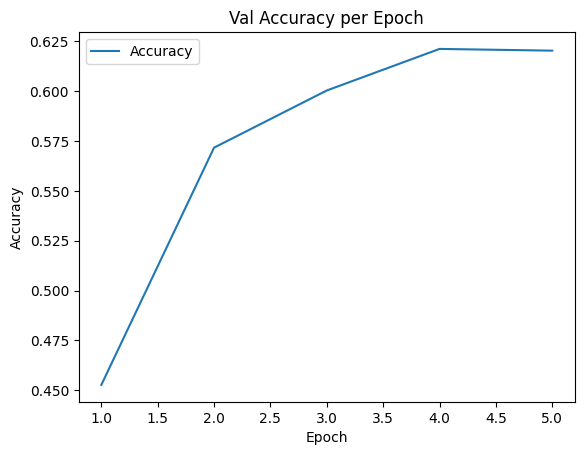

In [42]:
plt.plot(val_acc["epoch"],val_acc["eval_accuracy"], label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy per Epoch")
plt.legend()
plt.show()

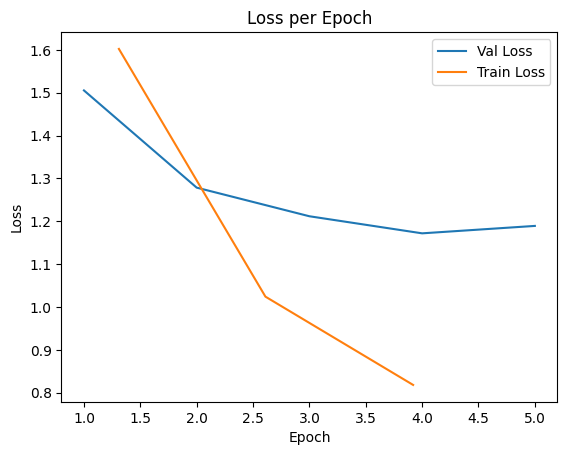

In [43]:
plt.plot(val_loss["epoch"],val_loss["eval_loss"], label="Val Loss")
plt.plot(train_loss["epoch"],train_loss["loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

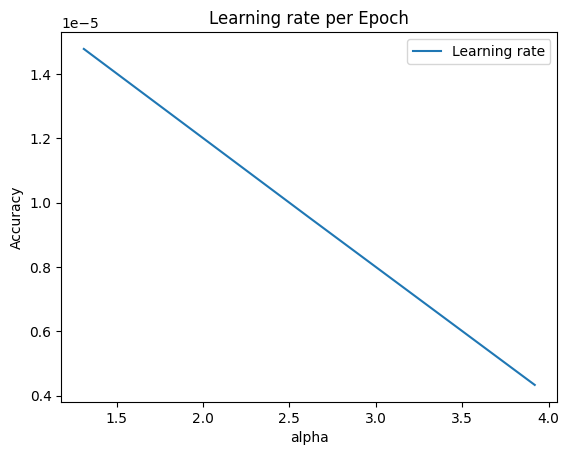

In [44]:
plt.plot(learning_rates["epoch"],learning_rates["learning_rate"], label="Learning rate")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Learning rate per Epoch")
plt.legend()
plt.show()